In [ ]:
import pandas as pd

In [ ]:
pod=pd.read_csv("detailed_info.csv")

In [ ]:
pod["docno"]=pod.docno.astype(str)
pod["title"]=pod.title.astype(str)
pod["description"]=pod.description.astype(str)
pod["genre"]=pod.genre.astype(str)
pod["rating"]=pod.rating.astype(str)
pod["num_reviews"]=pod.num_reviews.astype(str)

In [ ]:
import pyterrier as pt
import pandas as pd
import os
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [ ]:
pd_indexer = pt.DFIndexer("./index", overwrite=True, blocks=True)
indexref = pd_indexer.index(pod["description"], pod["docno"],pod["title"],pod["genre"],pod["rating"],pod["num_reviews"])

22:26:12.375 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (x80cs5bc) - further warnings are suppressed
22:26:28.356 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 2 empty documents


In [ ]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 4266
Number of terms: 17506
Number of postings: 151825
Number of fields: 0
Number of tokens: 178247
Field names: []
Positions:   true



In [ ]:
topics = pd.read_csv('./topics.csv') 
topics['qid'] = topics.qid.astype('str')
qrels = pd.read_csv('./qrels.csv') 
qrels['qid'] = qrels.qid.astype(str)
qrels['docno'] = qrels.docno.astype(str)

In [ ]:
RANK_CUTOFF = 30
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=0.3, random_state=SEED)
train_topics, valid_topics = train_test_split(tr_va_topics, test_size=0.1, random_state=SEED)

In [ ]:
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
qe = pt.rewrite.Bo1QueryExpansion(index)

In [ ]:
ltr_feats = (bm25%RANK_CUTOFF) >> pt.text.get_text(index, ["genre","title","rating","num_reviews"]) >> (
    pt.transformer.IdentityTransformer()
    **
    (bm25>>qe>>bm25)
    ** 
    (pt.text.scorer(body_attr="genre", wmodel='BM25') ) 
    ** 
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    **
    pt.apply.doc_score(lambda row: float(row["rating"]))
    **
    pt.apply.doc_score(lambda row: int(row["num_reviews"]))
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

22:26:35.905 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:36.681 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

CPU times: user 9.43 s, sys: 296 ms, total: 9.73 s
Wall time: 7.09 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.2s finished


In [ ]:
fnames=["bm25","qe","title","genre","rating","num_reviews"]
pt.Experiment(
    [ltr_feats >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])
     

22:26:39.588 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:39.905 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

22:26:41.278 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:41.619 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:43.563 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:44.026 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,bm25,0.302036,0.465319,0.673640,360.0
1,qe,0.302036,0.464706,0.675508,360.0
2,title,0.302036,0.468952,0.670551,360.0
3,genre,0.302036,0.462818,0.655695,360.0
4,rating,0.302036,0.476456,0.728740,360.0
5,num_reviews,0.302036,0.474864,0.708808,360.0


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

22:26:53.101 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:53.599 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

22:26:54.296 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:54.454 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
[1]	valid_0's ndcg@10: 0.539971
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's ndcg@10: 0.422651
[3]	valid_0's ndcg@10: 0.408545
[4]	valid_0's ndcg@10: 0.384564
[5]	valid_0's ndcg@10: 0.396664
[6]	valid_0's ndcg@10: 0.407223
Early stopping, best iteration is:
[1]	valid_0's ndcg@10: 0.539971
CPU times: user 4.19 s, sys: 91.1 ms, total: 4.28 s
Wall time: 3.49 s


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

In [ ]:

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

22:26:56.442 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:26:56.912 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

CPU times: user 4.78 s, sys: 122 ms, total: 4.9 s
Wall time: 3.92 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.2s finished


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
xg = xgb.XGBRegressor(max_depth = 20, learning_rate = 0.01, n_estimators = 100, objective = 'rank:pairwise')#rank:pairwise rank:ndcg
xg_pipe = ltr_feats >> pt.ltr.apply_learned_model(xg)
%time xg_pipe.fit(train_topics, qrels)

22:33:42.917 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:33:43.362 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

CPU times: user 3.21 s, sys: 49.8 ms, total: 3.26 s
Wall time: 3.68 s


In [ ]:
# all the models here use the same rank cutoff
pt.Experiment(
    [xg_pipe, lmart_x_pipe , rf_pipe, bm25%RANK_CUTOFF], 
    test_topics, 
    qrels, 
    names=["BM25+XGB", "BM25+LM","BM25+RF","BM25"], 
    baseline=0, 
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "ndcg_cut_5"])
     

22:33:44.840 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:33:45.118 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

22:33:47.365 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:33:47.628 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:33:48.686 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:33:48.933 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/content/index/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.al

,name,map,ndcg,ndcg_cut_5,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_5 +,ndcg_cut_5 -,ndcg_cut_5 p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25+XGB,0.302036,0.478097,0.747998,0.727821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25+LM,0.302036,0.469417,0.674077,0.689000,0.0,0.0,NaN,2.0,10.0,0.128155,2.0,10.0,0.055719,3.0,9.0,0.120012
2,BM25+RF,0.302036,0.472898,0.714768,0.716622,0.0,0.0,NaN,3.0,9.0,0.123651,3.0,7.0,0.154802,5.0,7.0,0.447885
3,BM25,0.302036,0.465319,0.649260,0.673640,0.0,0.0,NaN,4.0,8.0,0.059794,3.0,9.0,0.029942,4.0,8.0,0.062462


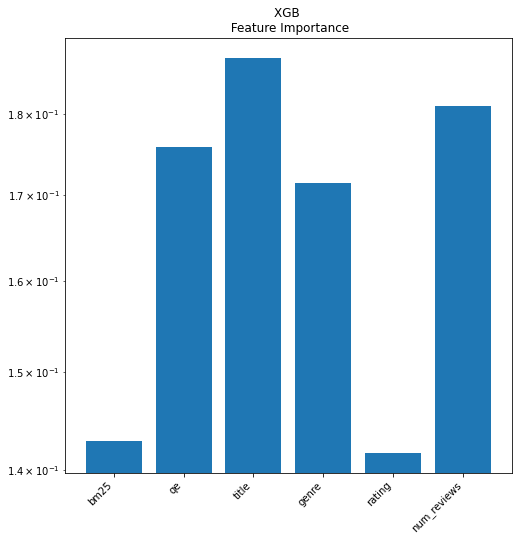

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0) = plt.subplots(1, 1, figsize=(8,8))

ax0.bar(np.arange(len(fnames)), xg.feature_importances_)
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("XGB \n Feature Importance")
ax0.set_yscale('log')


fig.show()